In [1]:
import pandas as pd
from tqdm import tqdm
import math
import json
import heapq  
from utils.contribution import contribution_chart
import sys
import os
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# 保证绝对路径可以被检测到
sys.path.append("\\".join(sys.path[0].split("\\")[:-1]))

In [2]:
id_test = 0
id_temporal_len = 100
graph_type='raw'#'raw' or 'simple'
# graph_type='simple'
test_set = 'd01_te'
test_path = 'E:/Lab/TEP-KG/data_tep/TEP-dataset/test/'+test_set+'.dat'
dataset_type = 'tep'
folder_path = './fig/'+dataset_type+'/'+test_set+'/'
if not os.path.isdir(folder_path):
    os.makedirs(folder_path)

9


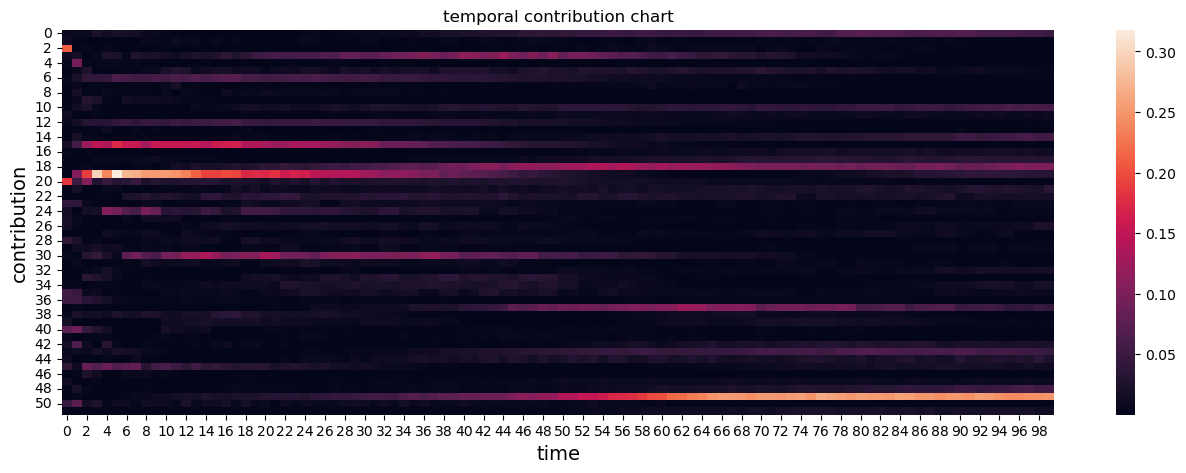

In [3]:
def preprocess_cont_chart(id_test,id_temporal_len,graph_type,test_path):
    t2_cont_list,spe_cont_list,rbc_cont_list,num_pc = contribution_chart(test_path,num_pc=0,PCA_components_rate=0.5,temporal=True,id_test=id_test,id_temporal_len=id_temporal_len,graph_type=graph_type)
    print(num_pc)
    cont_list = rbc_cont_list
    cont_list = cont_list[id_test:id_test+id_temporal_len]
    cont_list=cont_list/np.sum(cont_list,axis=1).reshape(-1,1)
    plt.figure(figsize=(16,5))
    ax = sns.heatmap(cont_list.transpose(),cbar=True) # vmin和vmax是自定义显示颜色的范围
    plt.title("temporal contribution chart") # 设置标题
    plt.xlabel("time", fontsize=14) # 设置x标题
    plt.ylabel("contribution", fontsize=14) # 设置y轴标题
    # plt.savefig(fig_name,bbox_inches='tight',dpi=300)
    plt.show()
    return cont_list
cont_list = preprocess_cont_chart(id_test,id_temporal_len,graph_type,test_path)

In [4]:
# best_x =[17.,  34.,  49., 200.,   5.,  10.,  10.,  13.]
best_x =[10,  30, 50., 200.,   1.,  5.,   8.,  20]
param_State_loss = best_x[0]/10
param_Output_loss = best_x[1]/10
param_Contain_loss = best_x[2]/10
param_Generate_loss = best_x[3]/10
param_State_disp = 1
param_Output_disp = 1
param_Contain_disp = 1
param_Generate_disp = 1
param_State_time = best_x[4]
param_Output_time = best_x[5]
param_Contain_time = best_x[6]
param_Generate_time = best_x[7]
relation_loss_dict = {'State_of':param_State_loss,'State':param_State_loss,'Output':param_Output_loss,'Contain':param_Contain_loss,'Contained_by':param_Contain_loss,'Generate':param_Generate_loss}
distance_punishment = {'State_of':param_State_disp,'State':param_State_disp,'Output':param_Output_disp,'Contain':param_Contain_disp,'Contained_by':param_Contain_disp,'Generate':param_Generate_disp}
relation_time_delay = {'State_of':param_State_time,'State':param_State_time,'Output':param_Output_time,'Contain':param_Contain_time,'Contained_by':param_Contain_time,'Generate':param_Generate_time}

if graph_type=='raw':
    variable_names = ['x'+str(i) for i in range(1,53)]
    with open('data_tep/graph.json', 'r') as f:
        kg_graph = json.load(f)

if graph_type=='simple':
    variable_names = ['x'+str(i) for i in range(1,23)]+['x'+str(i) for i in range(42,53)]
    with open('data_tep/simple_graph.json', 'r') as f:
        kg_graph = json.load(f)

stream_names = ['Stream '+str(i) for i in range(1,15)]
device_names = ['Reactor','Separator','Stripper','Compressor','Condenser']
substance_names = ['A','B','C','D','E','F','G','H']
key_order = variable_names+stream_names+device_names+substance_names
sorted_items = sorted(kg_graph.items(), key=lambda item: key_order.index(item[0]))
kg_graph = dict(sorted_items)
#节点最大传播次数
max_propagate_times = 10
mode = "simulate"
sequence_cont = [np.sum(cont) for cont in cont_list.transpose()]/np.sum(cont_list)


def func_sigmoid(x,p):
    sigmoid_x = 1 / (1 + np.exp(-p*x))
    y = (1-sigmoid_x)*2
    return y

def Depre_path_loss(path_loss):
    #根据路径长度计算折旧
    param_path_depre = 0.1
    # return math.exp(-param_path_depre*path_loss)
    return func_sigmoid(path_loss,param_path_depre)

def Depre_child_node(count_child):
    #子节点数目过多带来的损耗
    min_child_node = 1
    if count_child<min_child_node:
        return 1
    param_child_node = 0.01
    # return math.exp(-param_child_node*count_child)
    return func_sigmoid(count_child-min_child_node,param_child_node)

def Depre_propagated(propagate_times,dis_punish):
    #被传播带来的折旧
    return 1/(propagate_times*dis_punish)
    
class PriorityQueue(object):
    def __init__(self):
        self._queue = []
        self._index = 0

    def push(self, item):
        """
        队列由 (priority, index, item) 形式组成
        priority 增加 "-" 号是因为 heappush 默认是最小堆
        index 是为了当两个对象的优先级一致时，按照插入顺序排列
        """
        priority = item.time
        heapq.heappush(self._queue, (priority, self._index, item))
        self._index += 1

    def pop(self):
        """
        弹出优先级最高的对象
        """
        return heapq.heappop(self._queue)[-1]

    def qsize(self):
        return len(self._queue)

    def empty(self):
        return True if not self._queue else False

class TimeNode(object):
    def __init__(self, node, time):
        self.node = node
        self.time = time

    def __repr__(self):
        return "{0} - {1}".format(self.node, self.time)


def bfs_simulate(startnode,sequence_cont,relation_loss_dict,distance_punishment,relation_time_delay):
    pq = PriorityQueue()

    map_node_visit = {}#节点被访问次数，相当于节点被别的节点传播损耗的次数
    map_node_propagate = {}#节点作为visit节点的次数，相当于节点向别的节点传播损耗的次数
    map_node_simu_score = {}#节点的模拟得分
    map_node_propagated_score = {} #节点被其他节点传播的量，可以据此回溯到其主要影响节点
    for node in kg_graph.keys():
        map_node_visit[node] = 0
        map_node_propagate[node] = 0
        map_node_simu_score[node] = 0
        map_node_propagated_score[node] = {}
    timer = 0#计时器
    pq.push(TimeNode(startnode,timer))
    map_node_visit[startnode] = 1
    map_node_simu_score[startnode] = 1
    while pq.qsize():#保障还有元素
        for _ in range(pq.qsize()):#同一层级的node遍历
            #子节点得分计算
            visit_timenode = pq.pop()
            visit_node = visit_timenode.node
            map_node_propagate[visit_node]+=1
            for node in kg_graph[visit_node].keys():
                count_child = len(kg_graph[visit_node])
                #原始的广度优先搜索，每个节点只能被访问一次
                if mode == "bfs": 
                    if not map_node_visit[node]:
                        map_node_visit[node]+=1
                        relation = kg_graph[visit_node][node]
                        map_node_simu_score[node] += map_node_simu_score[visit_node]*Depre_path_loss(relation_loss_dict[relation])*1/count_child
                        pq.push(TimeNode(node,1))#不考虑时间问题
                #基于BFS的流程模拟方法，每个节点向别的节点传播损耗的次数有限制，当只能传播一次时，相当于访问了所有的边
                elif mode == "simulate":
                    if map_node_propagate[visit_node]<=max_propagate_times:
                        #visit_node->node 误差传播过程
                        relation = kg_graph[visit_node][node]
                        #visit节点的损耗需要根据其被传播的损耗进行折旧，然后再乘上路径损耗
                        propagate_error = map_node_simu_score[visit_node]*Depre_propagated(map_node_visit[visit_node],distance_punishment[relation])*Depre_path_loss(relation_loss_dict[relation])*Depre_child_node(count_child)
                        pq.push(TimeNode(node,timer+relation_time_delay[relation]))
                        map_node_simu_score[node] +=propagate_error
                        if visit_node not in map_node_propagated_score[node].keys():
                            map_node_propagated_score[node][visit_node]=0
                        map_node_propagated_score[node][visit_node]+=propagate_error
                        map_node_visit[node]+=1
                timer+=1
    #计算相似度
    start_cont = 1
    for i in range(0,len(variable_names)):
        if variable_names[i]==startnode:
            start_cont = sequence_cont[i]
    sequence_simu = [v*start_cont/map_node_simu_score[startnode] for v in map_node_simu_score.values()]
    sequence_cont = np.array(sequence_cont)
    sequence_simu = np.array(sequence_simu)[0:len(variable_names)]
    sim_score = np.dot(sequence_cont, sequence_simu) / (np.linalg.norm(sequence_cont) * np.linalg.norm(sequence_simu))
    return sim_score,sequence_simu,map_node_propagated_score

dict_simu_score = {}
dict_sequence_simu = {}
for startnode in key_order:
    dict_simu_score[startnode],dict_sequence_simu[startnode],map_node_propagated_score = bfs_simulate(startnode,sequence_cont,relation_loss_dict,distance_punishment,relation_time_delay)
sorted_items = sorted(dict_simu_score.items(), key=lambda item: item[1],reverse=True)
dict_simu_score = dict(sorted_items)
dict_simu_score

{'x4': 0.5598314514916005,
 'x45': 0.5570058746257773,
 'Stream 4': 0.5558175416906115,
 'C': 0.5444769857332318,
 'A': 0.5410065731911387,
 'B': 0.5381552799722619,
 'x1': 0.5236871765897404,
 'x44': 0.523407832375857,
 'Stream 1': 0.5200597526913736,
 'x20': 0.5163701789192771,
 'x50': 0.5116024034535642,
 'Compressor': 0.5097907969198525,
 'x46': 0.5093389527362073,
 'x19': 0.5063752076987383,
 'x16': 0.5044849485851937,
 'x15': 0.5011597145978837,
 'x18': 0.5011337239055743,
 'Stripper': 0.500518793867538,
 'x11': 0.49279947222026943,
 'x13': 0.49227637089849974,
 'Stream 14': 0.491902919816143,
 'Separator': 0.491902919816143,
 'x22': 0.4917901146922884,
 'Stream 10': 0.4912355084916663,
 'x12': 0.4911553147233687,
 'x23': 0.48995326469261796,
 'x48': 0.4898061157901592,
 'x14': 0.48881171984246913,
 'x25': 0.4872205521606958,
 'x24': 0.4833919953529125,
 'Stream 6': 0.48299426485673863,
 'x6': 0.4827731083857185,
 'Stream 8': 0.47883247208024,
 'Stream 5': 0.4782462564000078,
 'x

In [5]:
for startnode in dict_simu_score.keys():
    if startnode in variable_names:
        break
dict_simu_score[startnode],dict_sequence_simu[startnode],map_node_propagated_score = bfs_simulate(startnode,sequence_cont,relation_loss_dict,distance_punishment,relation_time_delay)

In [6]:
sequence_cont
indices_sorted = np.argsort(sequence_cont, axis=0)[-8:]
sorted_var = [variable_names[i] for i in sorted(indices_sorted)]
sorted_var

['x1', 'x4', 'x16', 'x19', 'x20', 'x31', 'x38', 'x50']

In [7]:
def backtrack(node,startnode):
    back_list = []
    while True:
        current_node = node
        current_path = map_node_propagated_score[current_node]
        max_node = ''
        max_value = 0
        for node in current_path.keys():
            # if node not in variable_names and (node,current_node) not in back_list:
            if node not in variable_names or node==startnode:
                if (current_node,node) not in back_list and (node,current_node) not in back_list:
                    if current_path[node]>max_value:
                        max_value = current_path[node]
                        max_node = node
        if max_value>0:
            node = max_node
            back_list.append((current_node,node))
            if node==startnode:
                break
        else:
            break  
    return back_list
for var in sorted_var:
    path = backtrack(var,startnode)
    print(path)

[('x1', 'Stream 1'), ('Stream 1', 'A'), ('A', 'x4')]
[('x4', 'Stream 4'), ('Stream 4', 'B'), ('B', 'x4')]
[('x16', 'Stripper'), ('Stripper', 'Stream 4'), ('Stream 4', 'x4')]
[('x19', 'Stripper'), ('Stripper', 'Stream 4'), ('Stream 4', 'x4')]
[('x20', 'Compressor'), ('Compressor', 'Separator'), ('Separator', 'Stream 14'), ('Stream 14', 'Condenser'), ('Condenser', 'Stream 7'), ('Stream 7', 'Reactor'), ('Reactor', 'Stream 6'), ('Stream 6', 'Stream 8'), ('Stream 8', 'Stream 5'), ('Stream 5', 'Stripper'), ('Stripper', 'Stream 4'), ('Stream 4', 'x4')]
[('x31', 'C'), ('C', 'x4')]
[('x38', 'Stripper'), ('Stripper', 'Stream 4'), ('Stream 4', 'x4')]
[('x50', 'Stripper'), ('Stripper', 'Stream 4'), ('Stream 4', 'x4')]


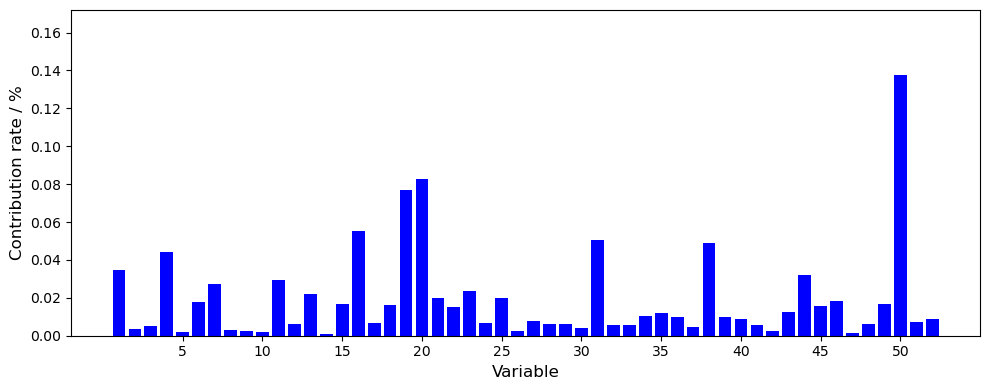

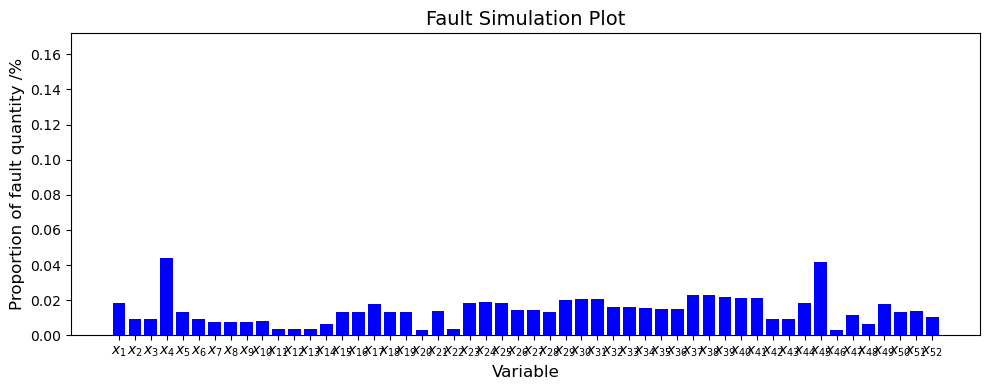

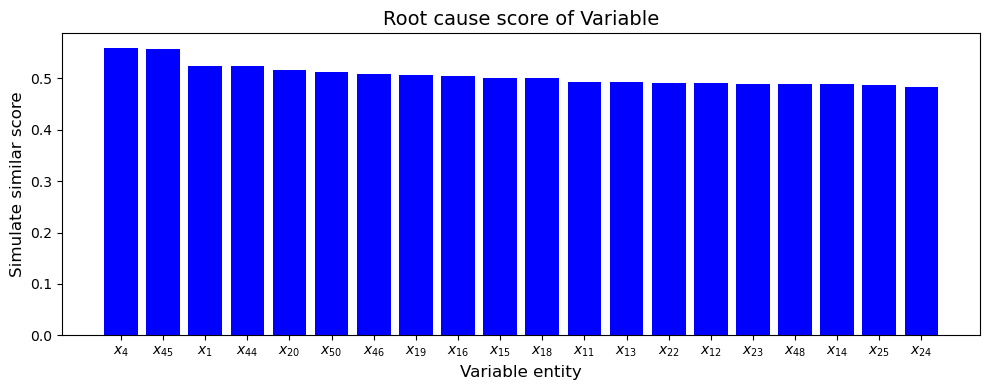

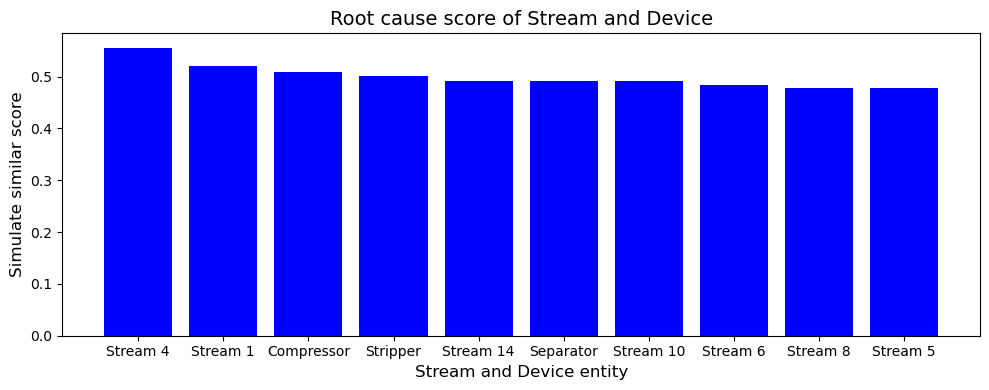

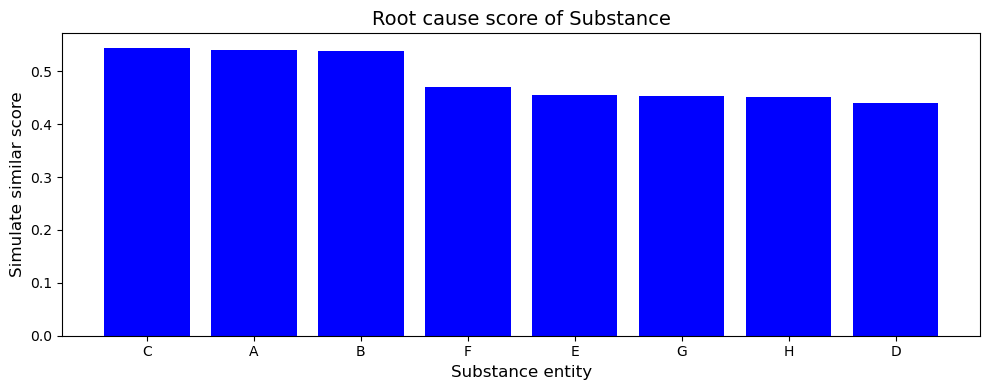

In [9]:
rank_node = [startnode for startnode in dict_simu_score.keys()]
for startnode in rank_node:
    if startnode in variable_names:
        best_start_node = startnode
        break

xlablefront = 12
ylablefront = 12
titlefront = 14
figxsize = 10
figysize = 4

def markdown_x(v):
    return '$'+v[:1]+'_{'+v[1:]+'}$'

def markdown_Stream(v):
    return v[:6]+' '+v[7:]

# plt.figure(figsize=(20,12))
plt.figure(figsize=(figxsize,figysize))
# plt.subplot(3,2,1)
# plt.bar([v[1:] for v in variable_names], sequence_cont, color='blue')
plt.bar([str(x) for x in range(1,53)], sequence_cont, color='blue')
plt.xticks([str(x) for x in range(5,53,5)])
# plt.xticks(rotation=90)
plt.xlabel('Variable', fontsize=xlablefront)
plt.ylabel('Contribution rate / %', fontsize=ylablefront)
# plt.title('RBC Contribution plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.25)
plt.tight_layout()
plt.savefig(folder_path+'contribution.png')

# plt.subplot(3,2,2)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_x(v) for v in variable_names], dict_sequence_simu[best_start_node], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable', fontsize=xlablefront)
plt.ylabel('Proportion of fault quantity /%', fontsize=ylablefront)
plt.title('Fault Simulation Plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.25)
plt.tight_layout()
plt.savefig(folder_path+'Simulation.png')

rank_var = [v for v in rank_node if v in variable_names][0:20]
# plt.subplot(3,2,3)
plt.figure(figsize=(figxsize,figysize))
plt.bar([markdown_x(v) for v in rank_var], [dict_simu_score[v] for v in rank_var], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Variable', fontsize=titlefront)
plt.tight_layout()
plt.savefig(folder_path+'Variable_score.png')

rank_sd = [v for v in rank_node if v in stream_names or v in device_names][0:10]
# plt.subplot(3,2,4)
plt.figure(figsize=(figxsize,figysize))
plt.bar([v for v in rank_sd], [dict_simu_score[v] for v in rank_sd], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Stream and Device entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Stream and Device', fontsize=titlefront)
# plt.tick_params(labelsize=8)
plt.tight_layout()
plt.savefig(folder_path+'Stream_Device_score.png')

# plt.subplot(3,2,5)
plt.figure(figsize=(figxsize,figysize))
plt.bar([v for v in rank_node if v in substance_names], [dict_simu_score[v] for v in rank_node if v in substance_names], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Substance entity', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('Root cause score of Substance', fontsize=titlefront)
plt.tight_layout()
plt.savefig(folder_path+'Substance_score.png')

plt.show()

In [10]:
save_csv_path = folder_path+'data.csv'
save_size = 10
concatenated_data = []
for i in range(0,save_size):
    concatenated_data.append([rank_var[i],round(dict_simu_score[rank_var[i]],5),rank_sd[i],round(dict_simu_score[rank_sd[i]],5)])
triples_df = pd.DataFrame(concatenated_data, columns=['variable','score','stream or device','score'])
triples_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')

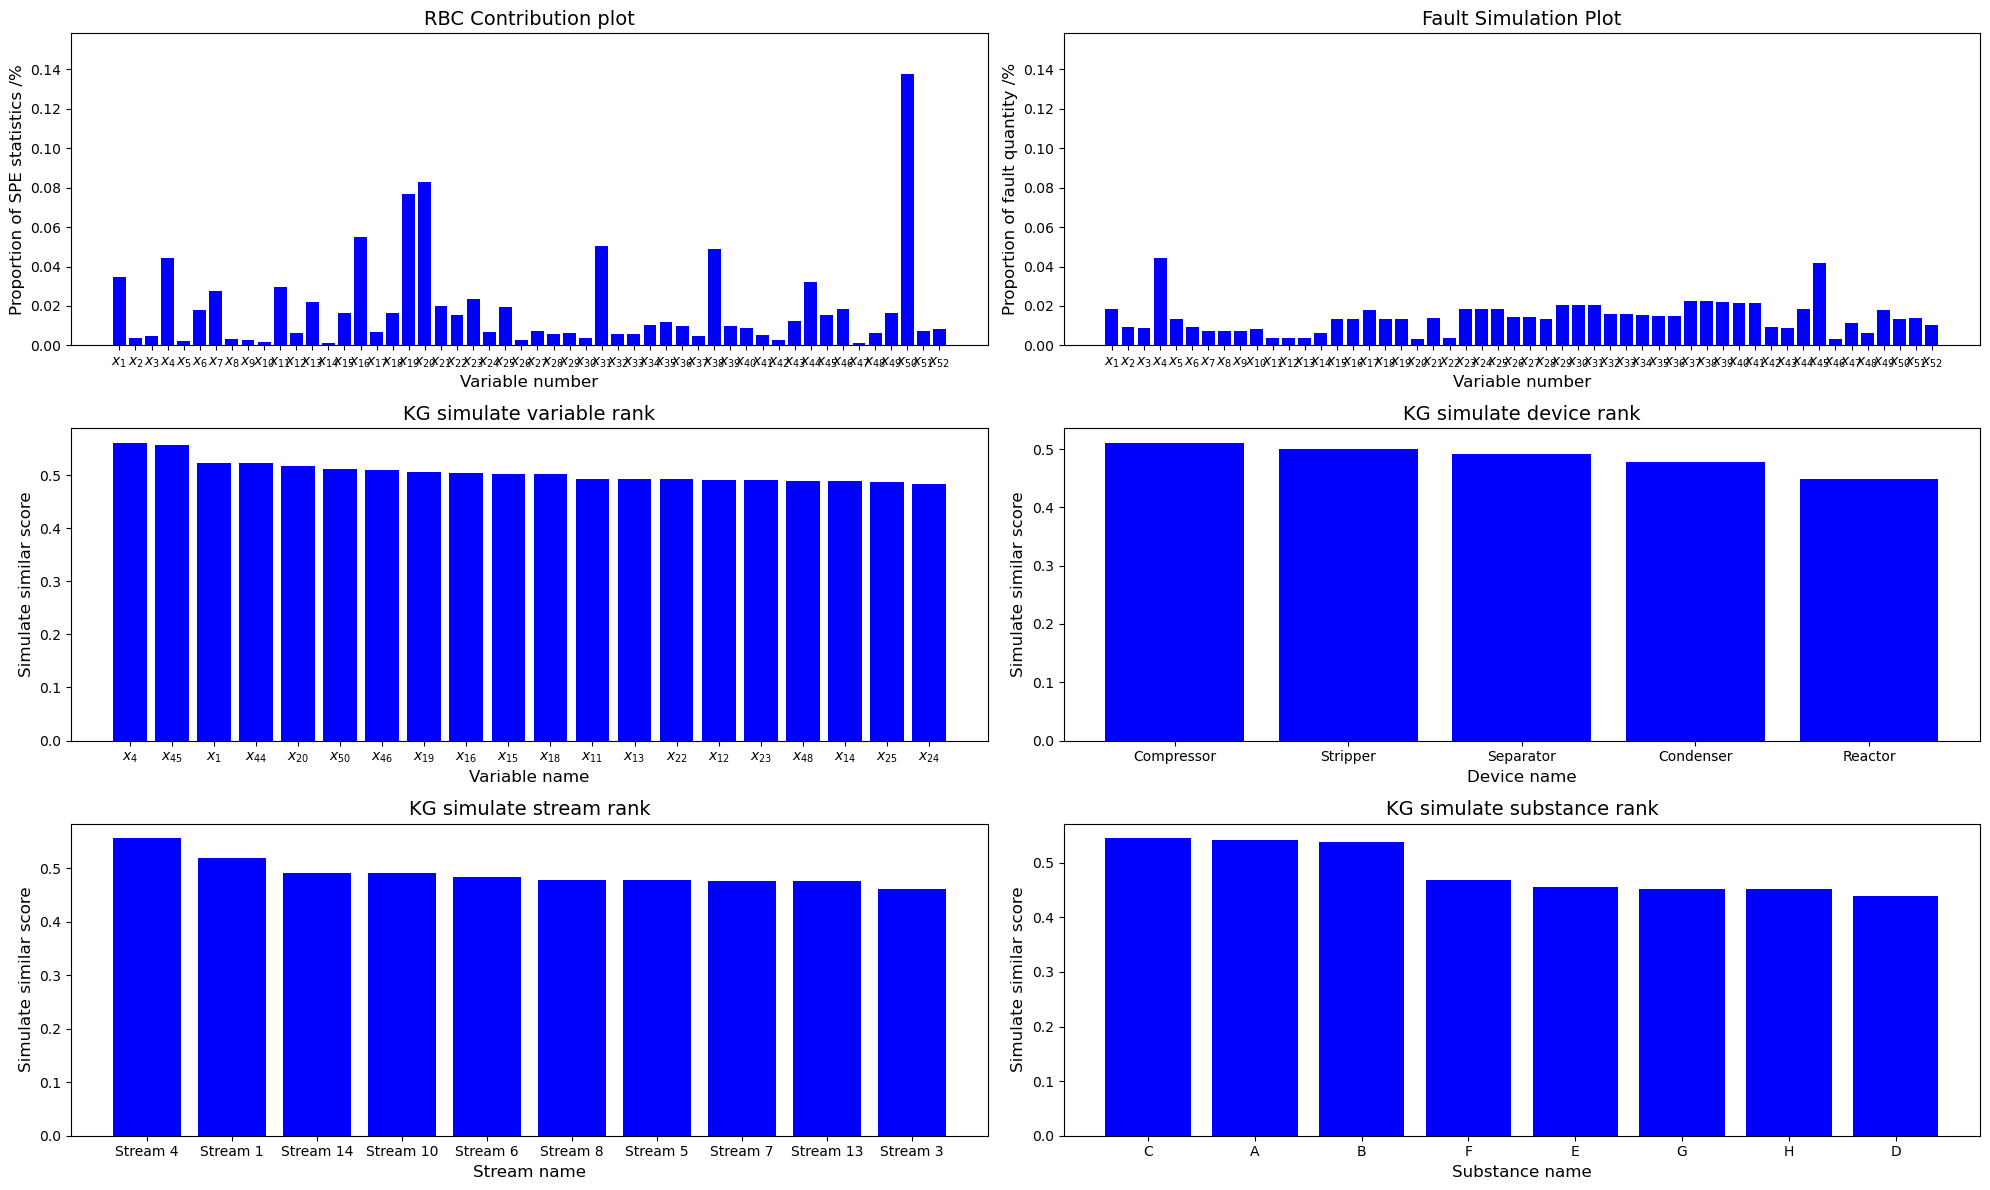

In [11]:
rank_node = [startnode for startnode in dict_simu_score.keys()]
for startnode in rank_node:
    if startnode in variable_names:
        best_start_node = startnode
        break

xlablefront = 12
ylablefront = 12
titlefront = 14

def markdown_x(v):
    return '$'+v[:1]+'_{'+v[1:]+'}$'

def markdown_Stream(v):
    return v[:6]+' '+v[7:]

plt.figure(figsize=(20,12))
plt.subplot(3,2,1)
plt.bar([markdown_x(v) for v in variable_names], sequence_cont, color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable number', fontsize=xlablefront)
plt.ylabel('Proportion of SPE statistics /%', fontsize=ylablefront)
plt.title('RBC Contribution plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.15)
plt.tight_layout()

plt.subplot(3,2,2)
plt.bar([markdown_x(v) for v in variable_names], dict_sequence_simu[best_start_node], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable number', fontsize=xlablefront)
plt.ylabel('Proportion of fault quantity /%', fontsize=ylablefront)
plt.title('Fault Simulation Plot', fontsize=titlefront)
plt.ylim(0, max(sequence_cont) * 1.15)
plt.tight_layout()


rank_var = [v for v in rank_node if v in variable_names][0:20]
plt.subplot(3,2,3)
plt.bar([markdown_x(v) for v in rank_var], [dict_simu_score[v] for v in rank_var], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Variable name', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('KG simulate variable rank', fontsize=titlefront)
plt.tight_layout()

plt.subplot(3,2,4)
plt.bar([v for v in rank_node if v in device_names], [dict_simu_score[v] for v in rank_node if v in device_names], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Device name', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('KG simulate device rank', fontsize=titlefront)
plt.tight_layout()

rank_stream = [v for v in rank_node if v in stream_names][0:10]
plt.subplot(3,2,5)
plt.bar([markdown_Stream(v) for v in rank_stream], [dict_simu_score[v] for v in rank_stream], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Stream name', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('KG simulate stream rank', fontsize=titlefront)
# plt.tick_params(labelsize=8)
plt.tight_layout()

plt.subplot(3,2,6)
plt.bar([v for v in rank_node if v in substance_names], [dict_simu_score[v] for v in rank_node if v in substance_names], color='blue')
# plt.xticks(rotation=90)
plt.xlabel('Substance name', fontsize=xlablefront)
plt.ylabel('Simulate similar score', fontsize=ylablefront)
plt.title('KG simulate substance rank', fontsize=titlefront)
plt.tight_layout()

plt.show()